## Common Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights
import datetime
import math
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

In [3]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train = h5py.File('../rec1501614399_export.hdf5', 'r')
test = h5py.File('../rec1501612590_export.hdf5', 'r')

### Dataset preprocessing

In [5]:
train_list = pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])
train_list['accelerator_pedal_position'] = list(train['accelerator_pedal_position'])
train_list['steering_wheel_angle'] = list(train['steering_wheel_angle'])
train_list['brake_pedal_status'] = list(train['brake_pedal_status'])

In [6]:
test_list = pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])
test_list['accelerator_pedal_position'] = list(test['accelerator_pedal_position'])
test_list['steering_wheel_angle'] = list(test['steering_wheel_angle'])
test_list['brake_pedal_status'] = list(test['brake_pedal_status'])

In [7]:
window_size = 10

In [8]:
classifier = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
classifier.heads = nn.Identity()
"""
classifier = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
classifier.classifier = nn.Identity()
"""


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 169MB/s]


'\nclassifier = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)\nclassifier.classifier = nn.Identity()\n'

In [9]:
classifier.to(device)
classifier.eval()
print("done")

done


In [10]:
img_transforms = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

In [11]:
train_frames = []
for i in range(len(train["aps_frame"])):
  img = np.flip(train["aps_frame"][i])
  img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
  img = img.unsqueeze(0)
  img = img.repeat(3, 1, 1)
  img = img_transforms(img.unsqueeze(0))
  with torch.no_grad():
    output = classifier(img)
    #output = output.squeeze(0) #output is already on device
    if len(train_frames) == 0:
      train_frames = output
    else:
      train_frames = torch.cat((train_frames, output), dim=0)
torch.save(train_frames, 'train_frames.pt')


In [12]:
print(train_frames.shape)

torch.Size([8192, 768])


In [13]:
test_frames = []
for i in range(len(test["aps_frame"])):
  img = np.flip(test["aps_frame"][i])
  img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
  img = img.unsqueeze(0)
  img = img.repeat(3, 1, 1)
  img = img_transforms(img.unsqueeze(0))
  with torch.no_grad():
    output = classifier(img)
    #output = output.squeeze(0) #output is already on device
    if len(test_frames) == 0:
      test_frames = output
    else:
      test_frames = torch.cat((test_frames, output), dim=0)
torch.save(test_frames, 'test_frames.pt')

## Concept differentiation: Image and sensor data are different things

In [14]:
"""
select n_heads, and d_model. d_model must be multiple of n_heads.
"""
n_heads = 8
d_model = 160 #20 * n_heads

In [15]:
img_repr_dim = 768
class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.sep = -1 * torch.ones(d_model, dtype=torch.float32,
                               device = device).unsqueeze(0)
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.sensor_ffn = nn.Sequential(
        nn.Linear(3, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp
    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )


  def forward(self, imgs, sensors, img_enc=None, sens_enc=None):
    imgs = self.img_ffn(imgs)
    sensors = self.sensor_ffn(sensors)
    imgs_encoded = imgs.clone().detach()
    sensors_encoded = sensors.clone().detach()

    # segment encoding
    if img_enc is not None:
      for idx in range(len(imgs)):
        imgs_encoded[idx] = imgs[idx].add(img_enc[idx])
    if sens_enc is not None:
      for idx in range(len(sensors)):
        sensors_encoded[idx] = sensors[idx].add(sens_enc[idx])

    x = torch.cat((imgs_encoded, self.sep, sensors_encoded), dim=0)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [16]:
policyNet=PolicyNet()
policyNet.to(device)
print(policyNet)
n_params = sum(p.numel() for p in policyNet.parameters() if p.requires_grad)
print(f"PolicyNet has {n_params} params")
print("done")

PolicyNet(
  (img_ffn): Sequential(
    (0): Linear(in_features=768, out_features=160, bias=True)
    (1): ReLU()
  )
  (sensor_ffn): Sequential(
    (0): Linear(in_features=3, out_features=160, bias=True)
    (1): ReLU()
  )
  (encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
    )
    (linear1): Linear(in_features=160, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=160, bias=True)
    (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=160, out_features=3, bias=True)
    (1): Sigmoid()
  )
)
PolicyNet has 885411 params
done


In [17]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.01)

In [18]:
%%time

alpha = 0.2

num_epochs = 10
losses = []
train_frames = torch.load("./train_frames.pt")

for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["aps_frame"])):

    sensors = [train_list['accelerator_pedal_position'][i]/100,
                  train_list['brake_pedal_status'][i],
                  (train_list['steering_wheel_angle'][i]+600)/1200]

    img = train_frames[i].squeeze(0)


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    optimizer.zero_grad()

    loss = criterion(output, sensors_queue_tensor[-1])
    # outliers prevention
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print(f"done epoch {epoch}.")

done epoch 0.
done epoch 1.
done epoch 2.
done epoch 3.
done epoch 4.
done epoch 5.
done epoch 6.
done epoch 7.
done epoch 8.
done epoch 9.
CPU times: user 5min 40s, sys: 3.78 s, total: 5min 44s
Wall time: 5min 50s


0.011375215444517766


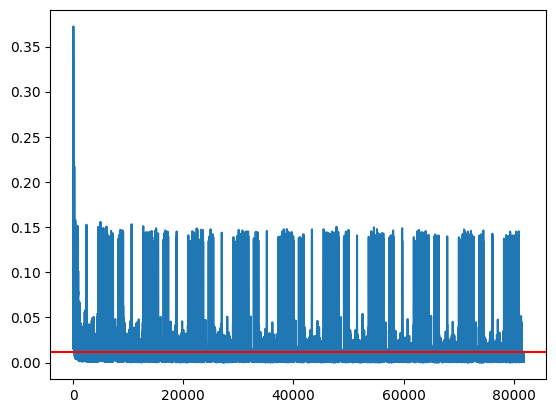

In [19]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [20]:
%%time

policyNet.eval()
losses = []
predictions = []
test_frames = torch.load("./test_frames.pt")
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["aps_frame"])):

    sensors = [test_list['accelerator_pedal_position'][i]/100,
                  test_list['brake_pedal_status'][i],
                  (test_list['steering_wheel_angle'][i]+600)/1200]


    img = test_frames[i].squeeze(0)


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    loss = criterion(output, sensors_queue_tensor[-1])

    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    predictions.append(output.tolist())

    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)

1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 16.9 s, sys: 58.3 ms, total: 17 s
Wall time: 17.2 s


avg loss: 0.02800846316956904
max loss: 0.21826837956905365
min loss: 9.412670624442399e-05


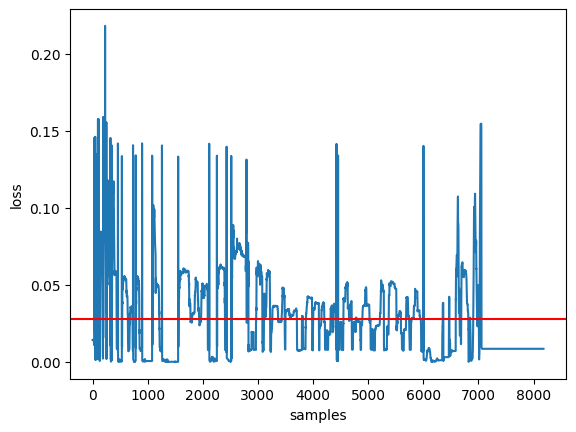

In [21]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [22]:
predictions_tensor=torch.tensor(predictions, dtype=torch.float32)
torch.save(predictions, "./policynet_pred_10.pt")

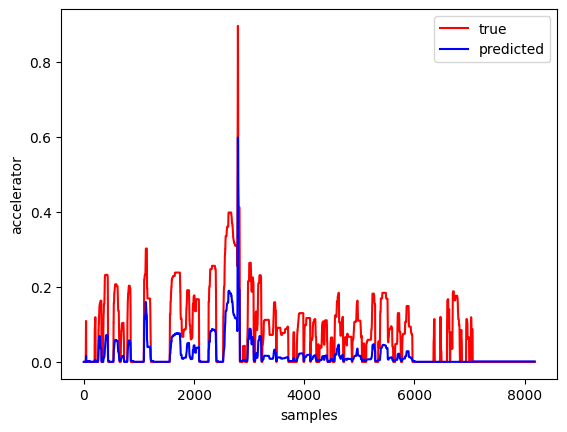

In [23]:
accelerations = [element[0] for element in predictions]
truth = test_list['accelerator_pedal_position'][window_size-1:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig("./acc_1_ep.png")
plt.show()

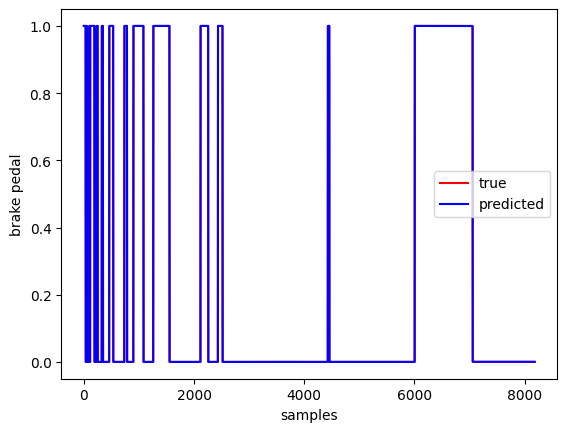

In [24]:
brakes = [element[1] for element in predictions]
truth = test_list['brake_pedal_status'][window_size-1:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig("./brk_1_ep.png")
plt.show()

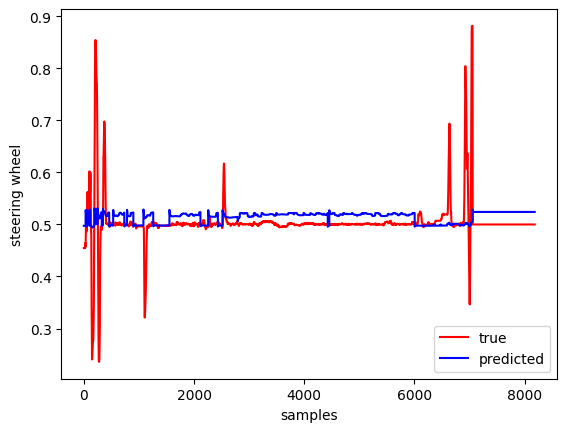

In [25]:
steers = [element[2] for element in predictions]
truth = test_list['steering_wheel_angle'][window_size-1:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig("./str_1_ep.png")
plt.show()

## Mobilenet as backbone

In [26]:

classifier = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
classifier.classifier = nn.Identity()
classifier.to(device)
classifier.eval()
img_transforms = MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 104MB/s]


In [27]:
"""
select n_heads, and d_model. d_model must be multiple of n_heads.
"""
n_heads = 8
d_model = 160 #20 * n_heads

In [28]:
img_repr_dim = 576
class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.sep = -1 * torch.ones(d_model, dtype=torch.float32,
                               device = device).unsqueeze(0)
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.sensor_ffn = nn.Sequential(
        nn.Linear(3, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp

    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )

  def forward(self, imgs, sensors):
    imgs = self.img_ffn(imgs)
    sensors = self.sensor_ffn(sensors)
    x = torch.cat((imgs, self.sep, sensors), dim=0)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [29]:
policyNet=PolicyNet()
policyNet.to(device)
policyNet.train()
print("done")

done


In [30]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.01)

In [31]:
%%time

num_epochs = 1
losses = []
alpha = 0.2
for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(train["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device
    sensors = [train_list['accelerator_pedal_position'][i]/100,
                  train_list['brake_pedal_status'][i],
                  (train_list['steering_wheel_angle'][i]+600)/1200]

    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    optimizer.zero_grad()
    loss = criterion(output, sensors_queue_tensor[-1])
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print(f"done epoch {epoch}.")

done epoch 0.
CPU times: user 2min 1s, sys: 1.01 s, total: 2min 2s
Wall time: 2min 4s


0.0882384053535986


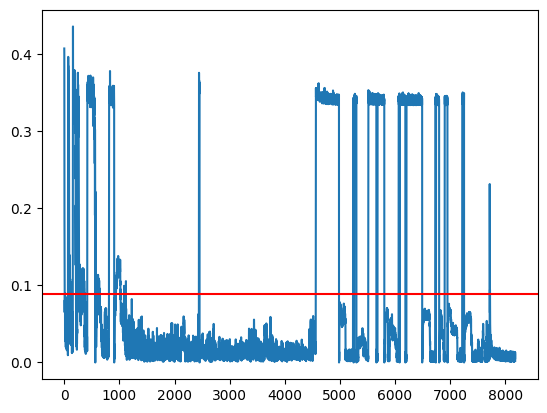

In [32]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.show()

In [33]:
%%time

policyNet.eval()
losses = []
predictions = []
alpha = 0.2
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(train["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device
    sensors = [train_list['accelerator_pedal_position'][i]/100,
                  train_list['brake_pedal_status'][i],
                  (train_list['steering_wheel_angle'][i]+600)/1200]

    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)


    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    loss = criterion(output, sensors_queue_tensor[-1])
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    predictions.append(output.tolist())

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break

    losses.append(loss.item())
  print(f"done epoch {epoch}.")

done epoch 0.
CPU times: user 1min 36s, sys: 582 ms, total: 1min 37s
Wall time: 1min 38s


avg loss: 0.11057008521380403
max loss: 0.39231061935424805
min loss: 0.0


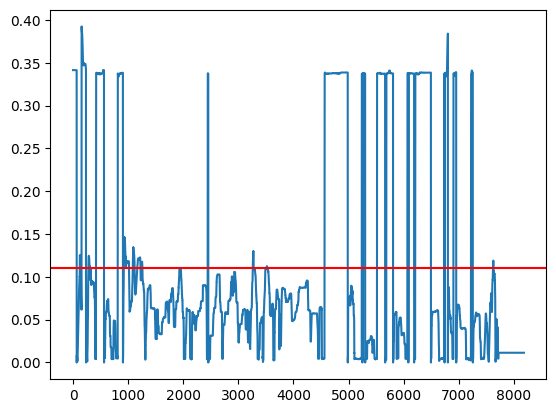

In [34]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.show()

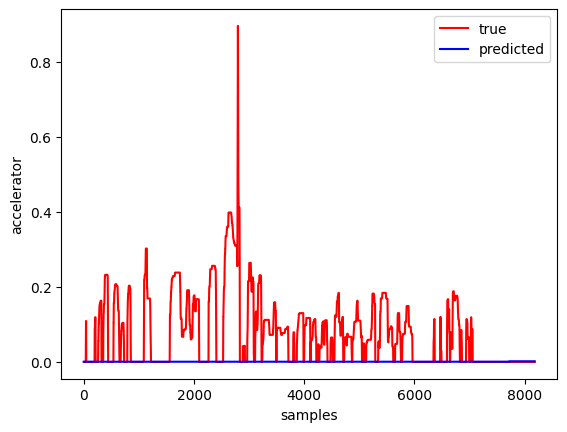

In [35]:
accelerations = [element[0] for element in predictions]
truth = test_list['accelerator_pedal_position'][window_size-1:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.show()

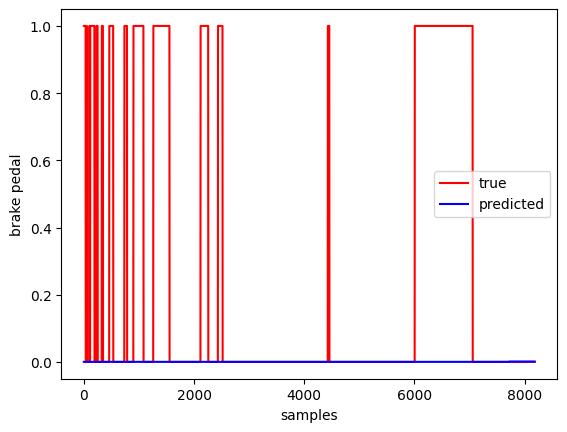

In [36]:
brakes = [element[1] for element in predictions]
truth = test_list['brake_pedal_status'][window_size-1:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.show()

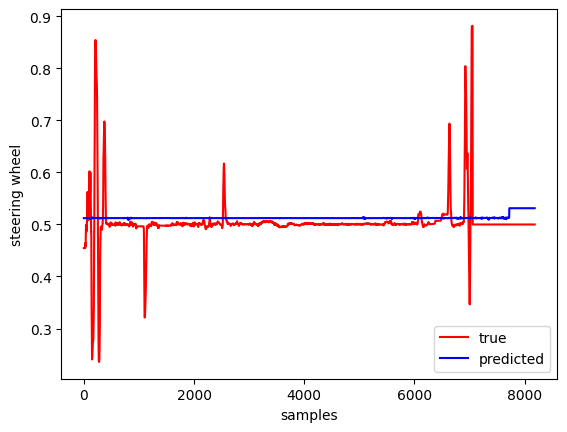

In [37]:
steers = [element[2] for element in predictions]
truth = test_list['steering_wheel_angle'][window_size-1:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.show()